In [7]:
import sys
sys.path.append("..")
import scanpy as sc
import muon as mu
from torch.utils.data import Dataset, random_split, Subset, DataLoader

import os
import argparse
import json
import time
import pandas as pd 
import numpy as np
from tqdm import tqdm

import torch
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, DistributedSampler
from torch import optim
from tensorboardX import SummaryWriter

from scmamba2.preprocess import Preprocessor, scATACseqPreprocessor
from scmamba2.dataset.dataset import MultiomeDataset
from scmamba2.models.scmamba import scMambaLMHeadModel
from scmamba2.models.config_scmamba import scMambaConfig
from scmamba2.loss import CLIPLoss
from scmamba2.trainer import Trainer
from scmamba2.utils.metrics import (
    biology_conservation, omics_mixing, mean_F1_silhouette
)
from scmamba2.utils.plot import plot_umap
from scmamba2 import logger

In [8]:
mdata = mu.read_h5mu("../datasets/label_transfer/ADWithCommonGenes.h5mu")
rna = mdata.mod['rna'].copy()
preprocessor_rna = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=False,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=True,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=20480,  # 5. whether to subset the raw data to highly variable genes
    hvg_use_key=None,
    hvg_flavor="seurat_v3",
    binning=0,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor_rna(rna, batch_key=None)
mdata.mod['rna'] = rna

# preprocess scATAC-seq dataset
atac = mdata.mod['atac'].copy()
preprocessor_atac = scATACseqPreprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=False,  # step 1
    filter_cell_by_counts=False,  # step 2
    binarize=True,  # 3. whether to binarize the raw data
    result_binarize_key="X_binarized", # the key in adata.layers to store the binarized data
    subset_hvg=40960,  # 4. whether to subset the raw data to highly variable genes
    hvg_use_key=None,
    hvg_flavor="seurat_v3",
    binning=0,  # 5. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor_atac(atac, batch_key=None)
mdata.mod['atac'] = atac
mu.pp.intersect_obs(mdata)
# mdata.write("../datasets/label_transfer/AD_pp.h5mu")

scMamba - INFO - Normalizing total counts ...
scMamba - INFO - Log1p transforming ...
scMamba - INFO - Subsetting highly variable genes ...
scMamba - WARNING - No batch_key is provided, will use all cells for HVG selection.
scMamba - INFO - Binarizing scATAC-seq cell-by-peak matrix ...
scMamba - INFO - Subsetting highly variable genes ...
scMamba - WARNING - No batch_key is provided, will use all cells for HVG selection.


In [9]:
select_genes = mdata.mod['rna'].var_names
mdata2 = mu.read_h5mu("../datasets/label_transfer/human_brain_3k.h5mu")
rna2 = mdata2.mod['rna']
rna2 = rna2[:, select_genes]

preprocessor_rna = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=False,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=True,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_use_key=None,
    hvg_flavor="seurat_v3",
    binning=0,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor_rna(rna2, batch_key=None)
# rna2.write("../datasets/label_transfer/human_brain_3k_rna_pp.h5ad")

scMamba - INFO - Normalizing total counts ...
scMamba - INFO - Log1p transforming ...


In [10]:
class SingleCellDataset(Dataset):
    def __init__(self, adata: sc.AnnData, use_layer: str,  omics: str='rna') -> None:
        super().__init__()
        self.adata = adata
        self.use_layer = use_layer
        self.omics = omics
    
    def __len__(self):
        return self.adata.X.shape[0]
    
    def __getitem__(self, index):
        if self.use_layer == "X_binned":
            x = self.adata.layers[self.use_layer][index].squeeze()
        elif self.use_layer != "X":
            x = self.adata.layers[self.use_layer][index].toarray().squeeze()
        else:
            x = self.adata.X[index].toarray().squeeze()
            
        return x

In [11]:
device = 'cuda:4'
seed = 42
torch.cuda.set_device(device)
adata = sc.read_h5ad("../datasets/label_transfer/human_brain_3k_rna_pp.h5ad")
out_dir = "../results/human_brain_3k_rna"
os.makedirs(out_dir, exist_ok=True)
dataset = SingleCellDataset(adata, use_layer='X_log1p')
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=False)

In [12]:
d_rna_feature = mdata.mod['rna'].X.shape[1]
d_atac_feature = mdata.mod['atac'].X.shape[1]

with open("../config_files/scmamba2_config.json", 'r') as file:
    config = json.load(file)
config_decoder1 = scMambaConfig(**config['decoder1'])
config_decoder2 = scMambaConfig(**config['decoder2'])

# Create model
model = scMambaLMHeadModel(
    config_omics1=config_decoder1,
    config_omics2=config_decoder2,
    d_feature_omics1=d_rna_feature,
    d_feature_omics2=d_atac_feature,
).to(device)

checkpoint = torch.load("../results/benckmark/AD_ppbatchsize64projection_dim64/checkpoints/scMamba.pt")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

scMamba - INFO - Getting scRNA-seq representation ...


scRNA-seq: 100%|██████████| 51/51 [00:09<00:00,  5.55it/s]


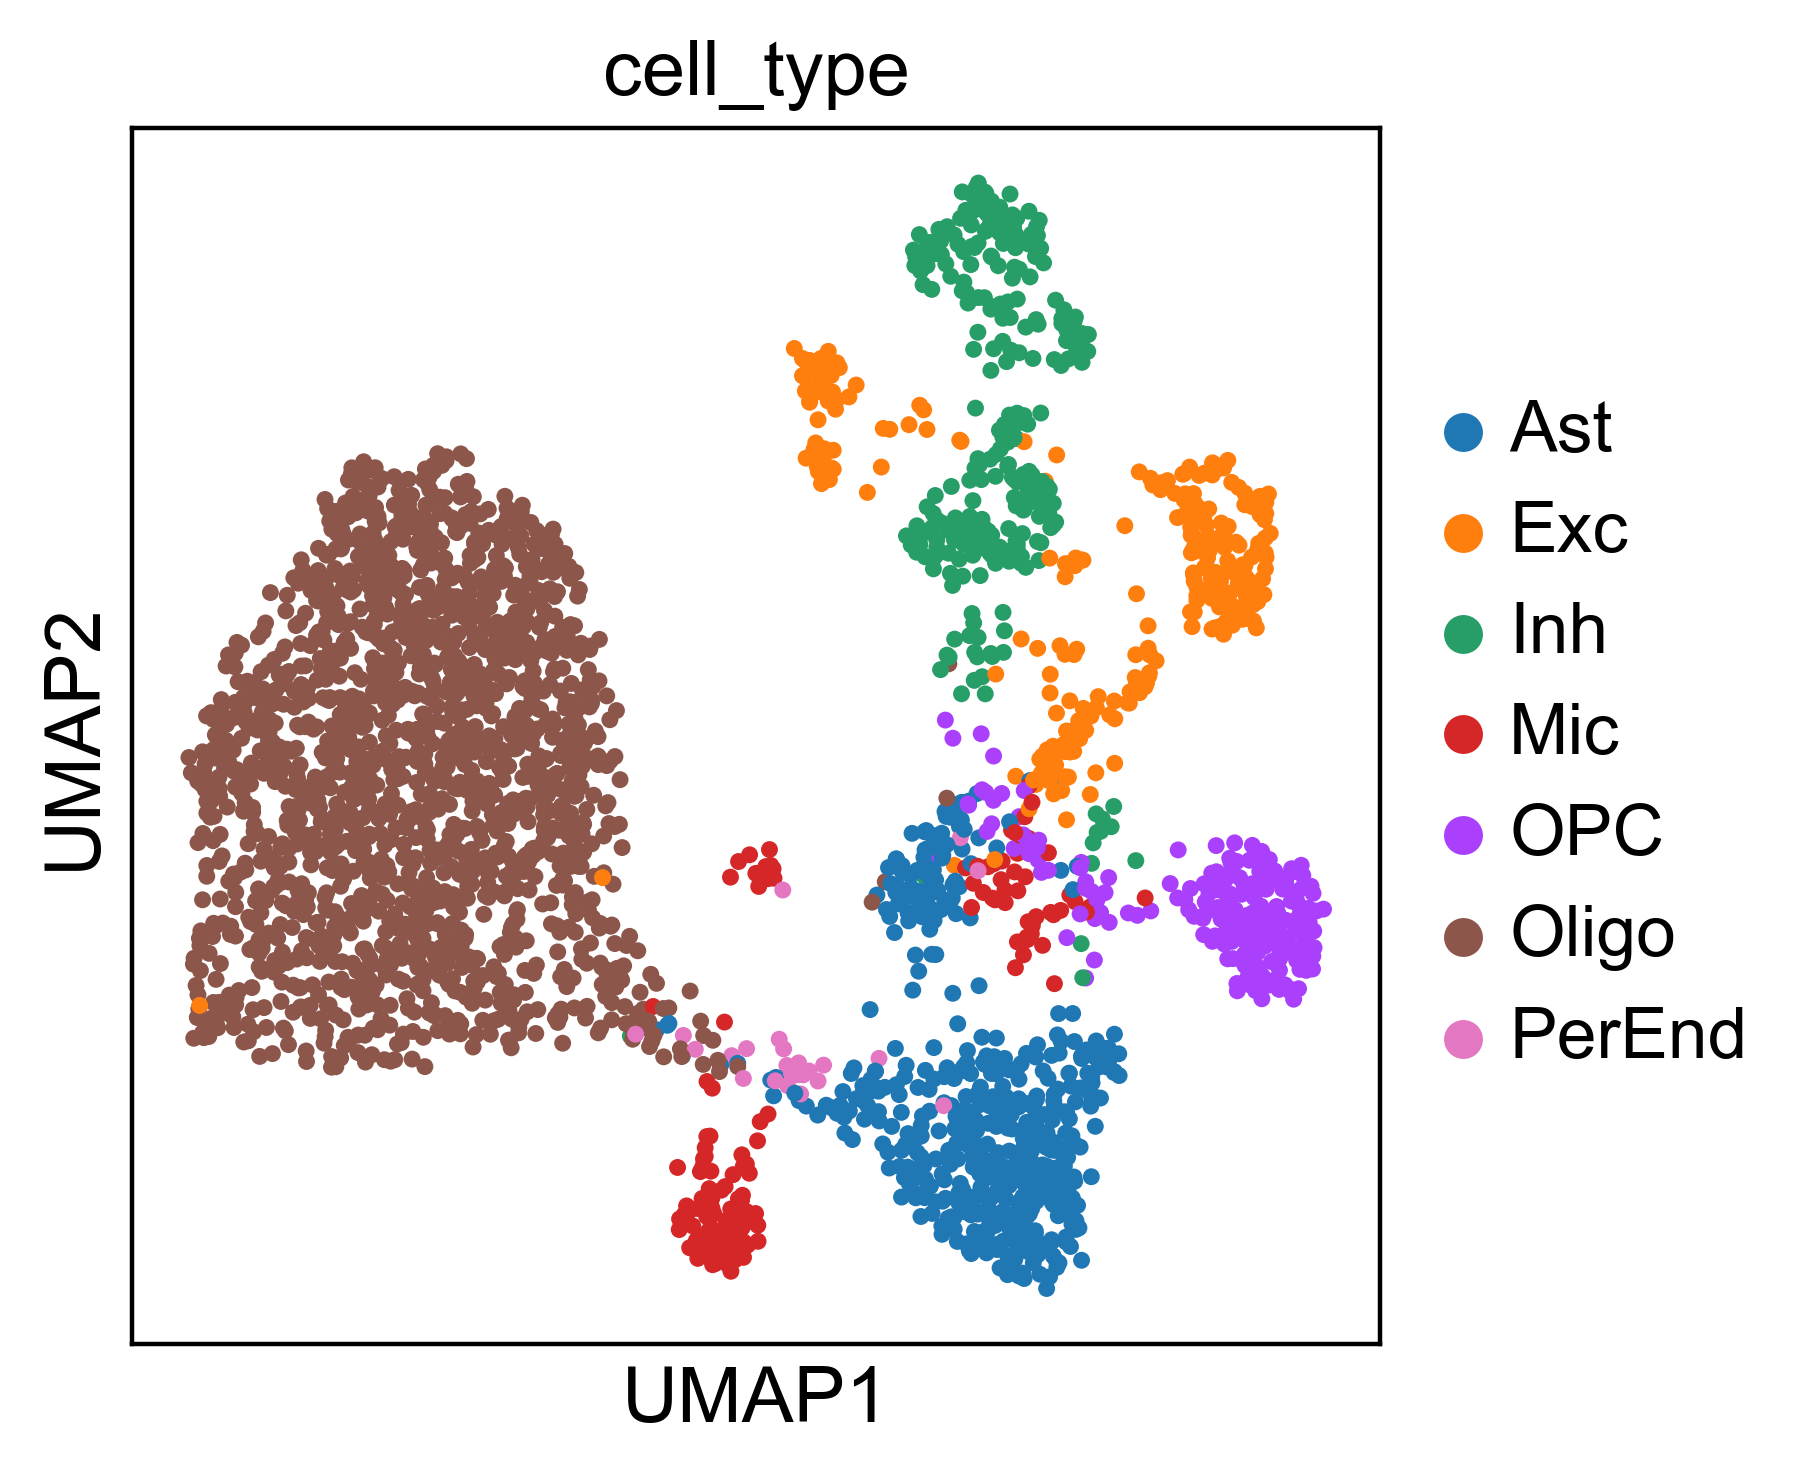

In [13]:
model.eval()    
with torch.no_grad():
    fn = model.decoder_omics1.forward
    logger.info("Getting scRNA-seq representation ...")
    adata = torch.concat(
        [
            fn(rna.to(device).float(), num_last_tokens=1).detach().cpu()
            for rna in tqdm(dataloader, desc="scRNA-seq")
        ]
    ).numpy()
    obs = dataloader.dataset.adata.obs
    adata = sc.AnnData(adata, obs=obs)
    sc.settings.figdir = out_dir
    plot_umap(
        adata, 
        color="cell_type",
        metric="cosine", 
        save="_rna.png",
        n_neighbors=30,
        min_dist=0.5,
        resolution=1
    )
    adata.write(f"{out_dir}/rna.h5ad")

## Cell type annotation

In [3]:
import scanpy as sc

device = 'cuda:4'
seed = 42
adata_train = sc.read_h5ad("../results/benckmark/AD_ppbatchsize64projection_dim64/rna.h5ad")
adata_test = sc.read_h5ad("../results/human_brain_3k_rna/rna.h5ad")

In [8]:
import sys
sys.path.append("..")
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, TensorDataset
from tensorboardX import SummaryWriter

from scmamba2.models import ClsDecoder

seed = 42
batch_size = 64
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = True

train_cell_type = adata_train.obs['cell_type']
test_cell_type = adata_test.obs['cell_type']

# encoder the cell types
label_encoder = LabelEncoder()
celltype_encoded = label_encoder.fit_transform(train_cell_type)
train_cell_type_encoded = label_encoder.transform(train_cell_type)
test_cell_type_encoded = label_encoder.transform(test_cell_type)

# transform to tensor
X_train_tensor = torch.tensor(adata_train.X, dtype=torch.float32)
y_train_tensor = torch.tensor(train_cell_type_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(adata_test.X, dtype=torch.float32)
y_test_tensor = torch.tensor(test_cell_type_encoded, dtype=torch.long)

# create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
# init the model
input_dim = adata_train.X.shape[1]
output_dim = len(label_encoder.classes_)
hidden_dim = 256
model = ClsDecoder(d_model=input_dim, n_cls=output_dim, nlayers=3, hidden_dim=hidden_dim).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Set up output directories and logging
out_dir = f"../results/annotation/human_brain_3k_batchsize64"
os.makedirs(out_dir, exist_ok=True)
writer = SummaryWriter(f'{out_dir}/runs/exp')

epochs = 30
model.train()
for epoch in range(epochs):
    epoch_loss = 0.0
    loop = tqdm(train_loader, total=len(train_loader), leave=False)
    for step, (X_emb, cell_type) in enumerate(loop):
        X_emb, cell_type = X_emb.to(device), cell_type.to(device)
        optimizer.zero_grad()
        outputs = model(X_emb)
        loss = criterion(outputs, cell_type)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        loop.set_description(f'Epoch [{epoch}/{epochs}]')
        loop.set_postfix(loss=loss.item())

    writer.add_scalar("train loss", epoch_loss / len(train_loader), epoch)
    
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        loop = tqdm(test_loader, total=len(test_loader), leave=False)
        for X_emb, cell_type in loop:
            X_emb, cell_type = X_emb.to(device), cell_type.to(device)
            outputs = model(X_emb)
            loss = criterion(outputs, cell_type)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += cell_type.size(0)
            correct += (predicted == cell_type).sum().item()

            loop.set_description(f'Validating Epoch [{epoch}/{epochs}]')
            loop.set_postfix(loss=loss.item(), accuracy=correct/cell_type.size(0))            
        
        accuracy = correct / total
        avg_loss = total_loss / len(test_loader)
    
    writer.add_scalar("val_loss", avg_loss, epoch)
    writer.add_scalar("val_accuracy", accuracy, epoch)

writer.close()

model.eval()
all_predictions = []
all_true = []
correct = 0
total = 0
with torch.no_grad():
    loop = tqdm(test_loader, total=len(test_loader), leave=False)
    for X_emb, cell_type in loop:
        X_emb, cell_type = X_emb.to(device), cell_type.to(device)
        outputs = model(X_emb)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_true.extend(cell_type.cpu().numpy())
        total += cell_type.size(0)
        correct += (predicted == cell_type).sum().item()
metrics = {}
metrics['acc'] = correct / total
metrics['f1_score'] = f1_score(all_true, all_predictions, average='weighted')
metrics['precision'] = precision_score(all_true, all_predictions, average='weighted')
metrics['recall'] = recall_score(all_true, all_predictions, average='weighted')
print(metrics)
if not os.path.exists(f'{out_dir}/metrics.csv'):
    metrics_df = pd.DataFrame([metrics])
else:
    metrics_df = pd.read_csv(
        f'{out_dir}/metrics.csv' 
    )
    new_metrics_df = pd.DataFrame([metrics])
    metrics_df = pd.concat([metrics_df, new_metrics_df], ignore_index=True)
metrics_df.to_csv(f'{out_dir}/metrics.csv', index=False)

decoded_predictions = label_encoder.inverse_transform(all_predictions)
adata_test.obs['cell_type_prediction'] = decoded_predictions
adata_test.write(f"{out_dir}/adata_prediction.h5ad")

{'acc': 0.9492731209403031, 'f1_score': 0.9482314785038403, 'precision': 0.9516288106541912, 'recall': 0.9492731209403031}


In [18]:
metrics

{'acc': 0.9492731209403031,
 'f1_score': 0.9482314785038403,
 'precision': 0.9516288106541912,
 'recall': 0.9492731209403031}